In [5]:
# Copy of fake_detection.ipynb but with sid_extragal_short_gr_100_rchi2min3.dat data set
# Find most realistic simulations to real ztf_dr4 data

In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest

from pathlib import Path

import os
import sys
from validutils_zwad.read_data import read_data

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Read in light curves of fakes...see how convincing they are

ZTF_FILTERS = 'gr'
# using simlib from data
X42, y42 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL42_SNII-NMF.pkl.gz')
X60, y60 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL60_SLSN-I.pkl.gz')
X62, y62 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL62_SNIbc-MOSFIT.pkl.gz')
X64, y64 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL64_TDE.pkl.gz')
X90, y90 = read_data('./ztf_dr3_sim_data/ZTF_SIMS_ALLMODELS_3RD_RUN/PALEO_ZTF_MODEL90_SNIa-SALT2.pkl.gz')

In [8]:


def plot_lightcurves_id(idx, X, f, compare_file):    
    
    nrows,ncols = 1,2
    figsize=(8, 4)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4), squeeze=False)
    plt.gca().invert_yaxis()
    
    flux = []
    for f in ZTF_FILTERS:
        if len(X.loc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.loc[idx]['fluxcal_' + f]))
            
    if compare_file is not None:
        real_SNIa = pd.read_csv(compare_file)
        peakmag = np.min(real_SNIa['Mag'])
        peakmjd = real_SNIa.loc[real_SNIa['Mag']==peakmag]['MJD']
        real_SNIa['FromPeak'] = real_SNIa['MJD'] - peakmjd.values

        # Turn mag to calibrated flux (fluxcal=10**(-0.4·mag+11))
        real_SNIa_g = real_SNIa[real_SNIa['Filter']=='g']
        real_SNIa_r = real_SNIa[real_SNIa['Filter']=='R']
        
        ax[0,0].errorbar(real_SNIa_g['FromPeak'], real_SNIa_g['Mag'], real_SNIa_g['MagErr'],
                            fmt='+', label='{}'.format(compare_file[:-4]))
        ax[0,1].errorbar(real_SNIa_r['FromPeak'], real_SNIa_r['Mag'], real_SNIa_r['MagErr'],
                            fmt='+', label='{}'.format(compare_file[:-4]))

        
        
        for i, (axi, f) in enumerate(zip(ax.flat, ZTF_FILTERS)):
            
            
            axi.errorbar(X.loc[idx]['mjd_%s' % f] - X.loc[idx]['pkmjd'], 
                            X.loc[idx]['mag_%s' % f], X.loc[idx]['magerr_%s' % f], 
                            fmt='+', label='Model = {}, #OBS= {}'.format(X.loc[idx]['SIM_MODEL_NAME'].replace(' ', ''), len(X.loc[idx]['mjd_%s' % f]))) 
            

            rowid = i // ncols
            colid = i % ncols
            #axi.set_xlim(-100,300)
            #axi.set_ylim(np.max(X.loc[idx]['mag_%s' % f]), np.min(X.loc[idx]['mag_%s' % f]))
            axi.set_ylim(23,16)
            axi.set_xlabel('MJD')
            axi.set_ylabel('Magnitude')
            axi.set_title('ID = {}, {}-band'.format(X.loc[idx]['snid'], f))
            ax[0,0].legend(loc='upper right', bbox_to_anchor=(0.5, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)
            ax[0,1].legend(loc='upper right', bbox_to_anchor=(0.6, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)

    if compare_file is None:

        for i, (axi, f) in enumerate(zip(ax.flat, ZTF_FILTERS)):
            axi.errorbar(X.loc[idx]['mjd_%s' % f] - X.loc[idx]['pkmjd'], 
                            X.loc[idx]['mag_%s' % f], X.loc[idx]['magerr_%s' % f], 
                            fmt='+', label='Model = {}, #OBS= {}'.format(X.loc[idx]['SIM_MODEL_NAME'].replace(' ', ''), len(X.loc[idx]['mjd_%s' % f]))) 

            rowid = i // ncols
            colid = i % ncols
            axi.set_xlim(-100,200)
            #axi.set_ylim(25,16)
            axi.set_xlabel('MJD')
            axi.set_ylabel('Magnitude')
            axi.set_title('ID = {}, {}-band'.format(X.loc[idx]['snid'], f))
            ax[0,0].legend(loc='upper right', bbox_to_anchor=(0.9, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)
            ax[0,1].legend(loc='upper right', bbox_to_anchor=(1.3, -0.15), ncol=2, fancybox=True, shadow=True, fontsize=12)

In [9]:
# First of all: load data

from zwad.utils import load_data

def feature_file(oid_file):
    parent = oid_file.parent
    if oid_file.name.startswith('oid_'):
        name = oid_file.name.replace('oid_', 'feature_')
    else:
        name = oid_file.name.replace('sid_', 'feature_')
    
    return parent.joinpath(name)
    

datadir = Path('../features_data', 'dr4_new')
sid_extragal_gr = datadir.joinpath('sid_extragal_short_gr_100_rchi2min3.dat')
feature_extragal_gr = feature_file(sid_extragal_gr)

fakesdir = Path('../sim_fake', 'output')
sid_fakes = list(fakesdir.glob('oid_*.dat'))
feature_fakes = [feature_file(s) for s in sid_fakes]

sids, features = load_data([sid_extragal_gr] + sid_fakes, [feature_extragal_gr] + feature_fakes)

In [10]:
sid_fakes

[PosixPath('../sim_fake/output/oid_sim_62_SNIbc.dat'),
 PosixPath('../sim_fake/output/oid_sim_42_SNII-NMF.dat'),
 PosixPath('../sim_fake/output/oid_sim_64_TDE.dat'),
 PosixPath('../sim_fake/output/oid_sim_90_SNIa.dat'),
 PosixPath('../sim_fake/output/oid_sim_60_SLSN-I.dat')]

# TODO: recalculate FAKES DETECTIONS CURVES AFTER DROPPED FEATURES!

In [11]:
%%time

# Perform calculations of outliers

isoforest = IsolationForest(n_subsamples=1024, n_trees=1000) # n_subsamples=1024, n_trees=1000
isoforest.fit(features)
scores = isoforest.score_samples(features)
ordered_sids = sids[np.argsort(scores)]
detection_curve = np.cumsum(ordered_sids < 1e10)

CPU times: user 1min 29s, sys: 266 ms, total: 1min 29s
Wall time: 1min 30s


In [12]:
len(ordered_sids[ordered_sids < 1e10])

1480

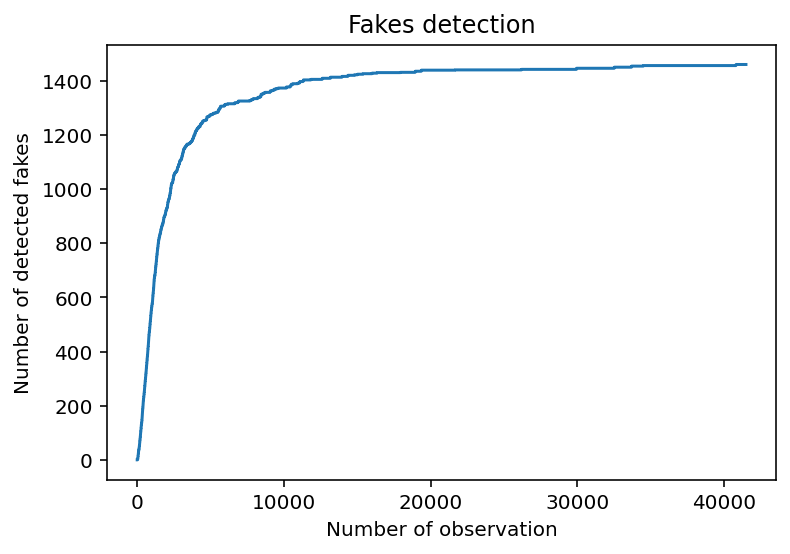

In [13]:
# Plot the detection curve

n_fakes = detection_curve[-1]

plt.plot(detection_curve[:n_fakes+40000]) # 10000 is for extragal_short_gr_100.tar
plt.xlabel('Number of observation')
plt.ylabel('Number of detected fakes')
plt.title('Fakes detection')
pass

In [14]:
n_fakes - detection_curve[60000]

16

In [15]:
#n_fakes - detection_curve[1000000]

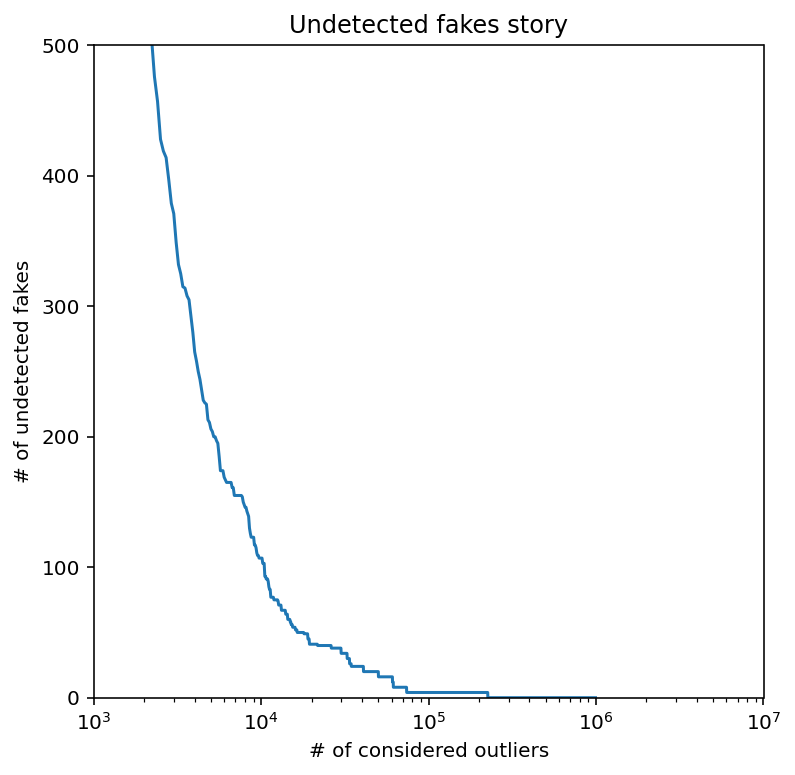

In [16]:
plt.figure(figsize=(6, 6))
plt.title('Undetected fakes story')
plt.plot(np.arange(0, len(detection_curve), 100), n_fakes - detection_curve[::100])
plt.xlabel('# of considered outliers')
plt.xlim(1e3, 1e7)
plt.xscale('log')
plt.ylabel('# of undetected fakes')
plt.ylim(0, 500)
pass

In [17]:
%%time

isoforest = IsolationForest(n_subsamples=1024, n_trees=10000)
isoforest.fit(features)
fake_trees = PineForest.filter_trees(isoforest.trees, features[-n_fakes:], np.full(n_fakes, -1), 9000)

CPU times: user 43.6 s, sys: 576 ms, total: 44.2 s
Wall time: 44.4 s


In [18]:
def get_most_frequent_roots(trees, n_hits=10):
    bins = np.bincount([tree.__getstate__()['nodes'][0]['feature'] for tree in trees])
    sort_index = np.argsort(bins)[::-1]
    sorted_bins = bins[sort_index]
    index = np.argwhere(sorted_bins >= n_hits).ravel()
    return sort_index[index]

In [19]:
roots = get_most_frequent_roots(fake_trees, n_hits=25) #30 in original returns none
roots

array([77, 64, 72, 60,  8, 19, 67, 61, 59, 94, 76,  7, 23])

In [20]:
feature_names = Path('../features_data', 'dr4_new', 'feature_extragal_short_gr_100_rchi2min3.name').open('r').read().split('\n')


def plot_feature_histogram(feature):
    values = features[:, feature]
    bins = np.linspace(values.min(), values.max(), 30)

    plt.figure()
    plt.title(f'Feature #{feature}({feature_names[feature]}) histogram')
    plt.hist(values[:-n_fakes], bins=bins, alpha=0.5, label='dr4')
    plt.hist(values[-n_fakes:], bins=bins, alpha=0.5, label='fakes')
    plt.yscale('log')
    plt.legend()
    
    dr4_value = values[:-n_fakes]
    fakes_value = values[-n_fakes:]
    
    return dr4_value, fakes_value, feature_names[feature]

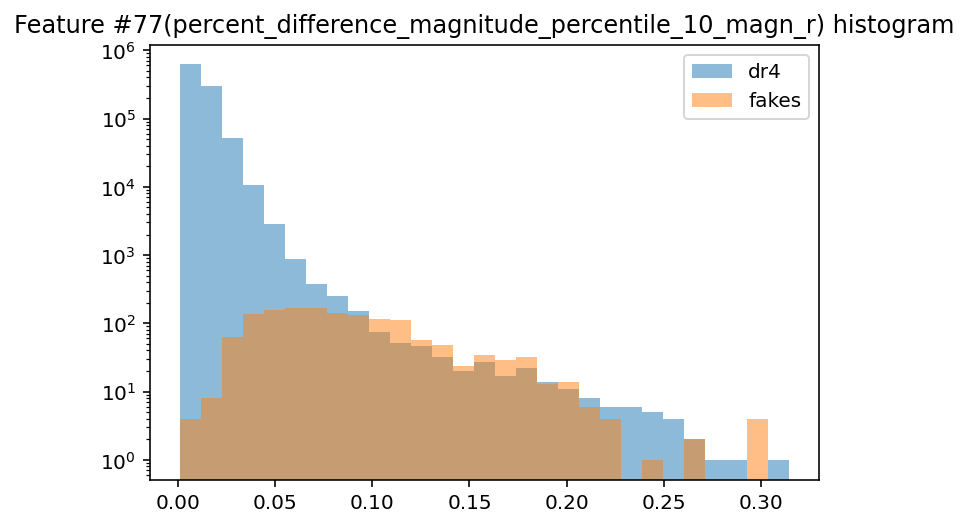

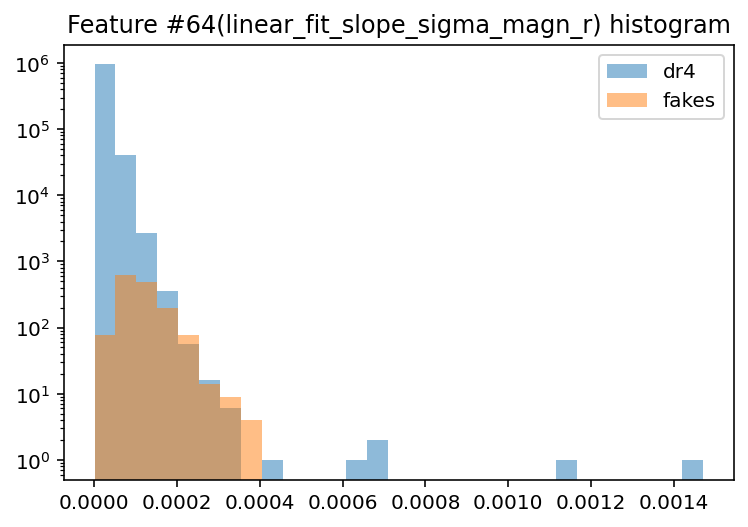

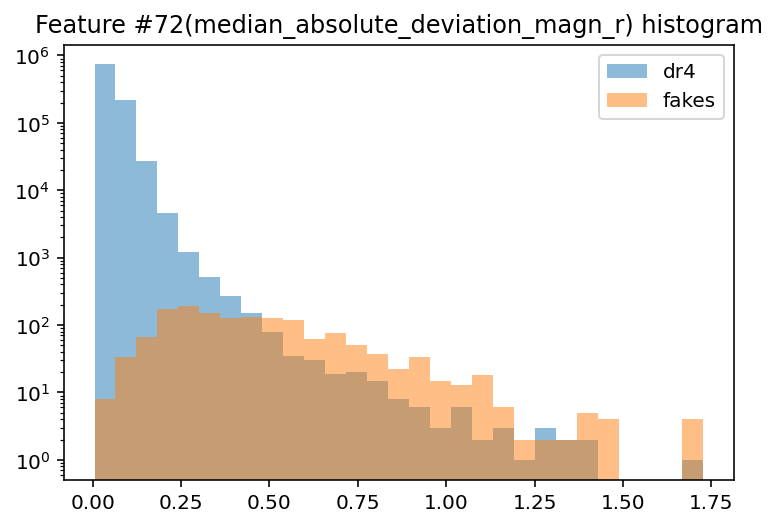

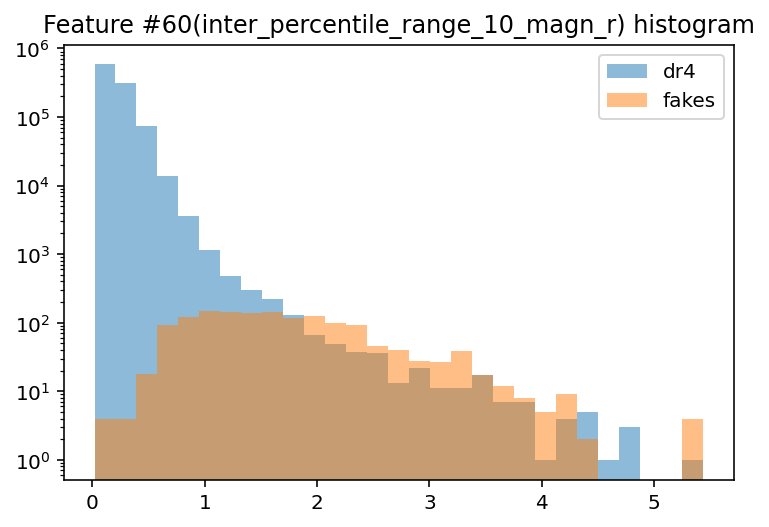

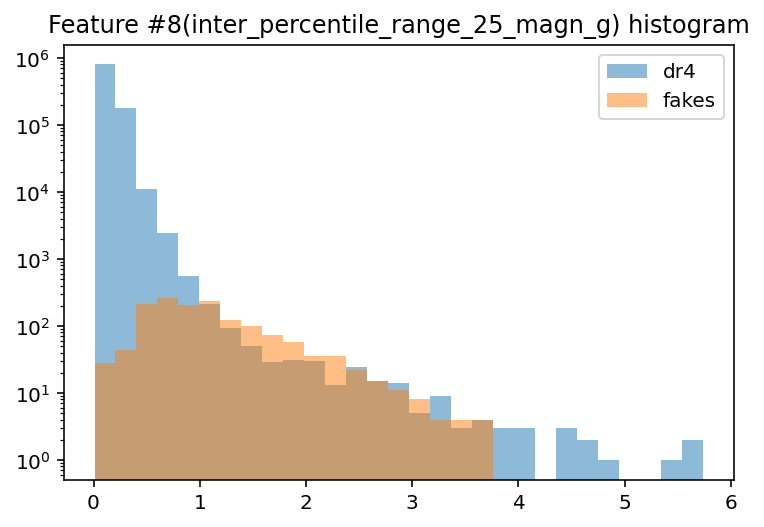

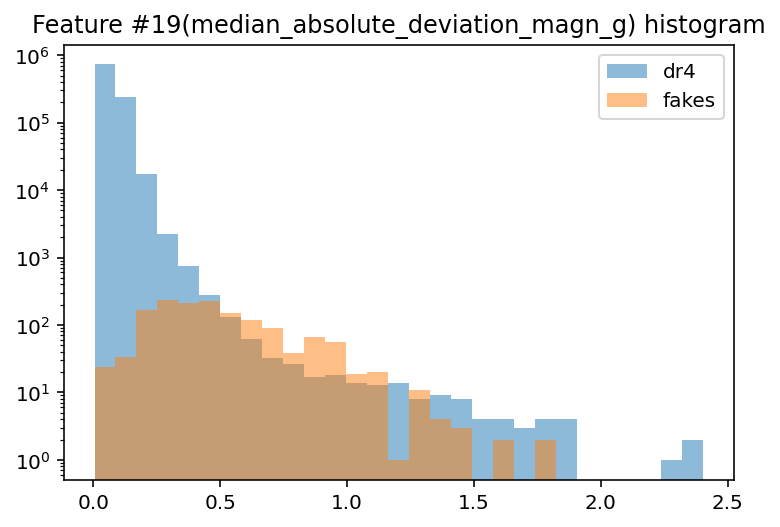

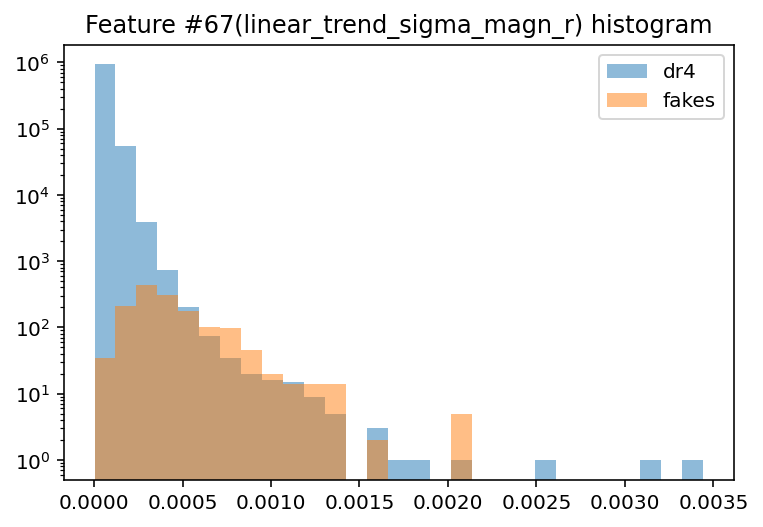

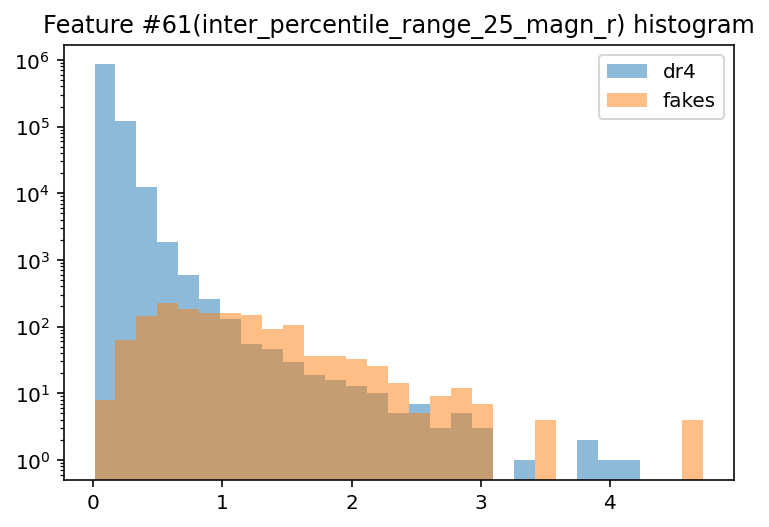

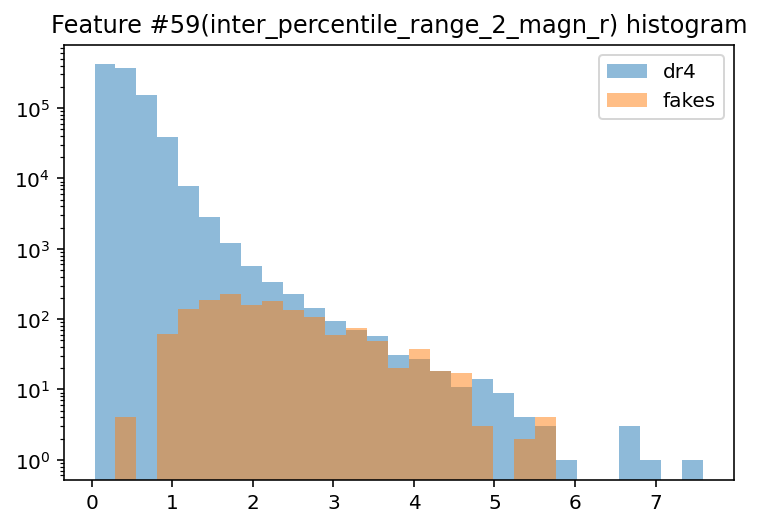

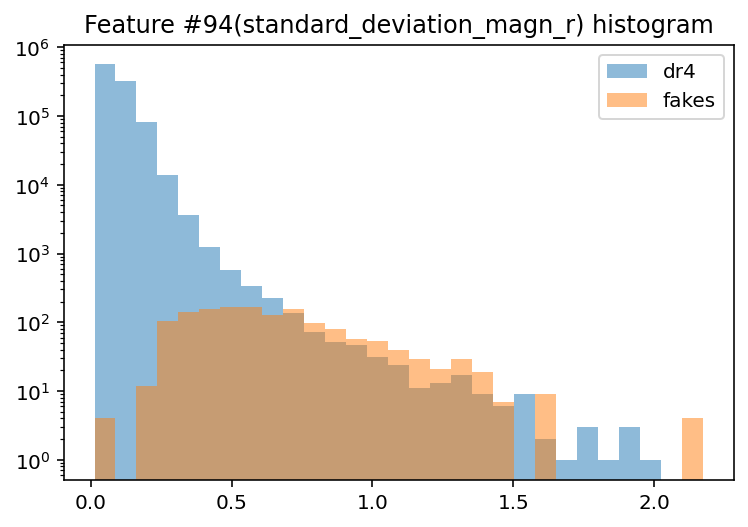

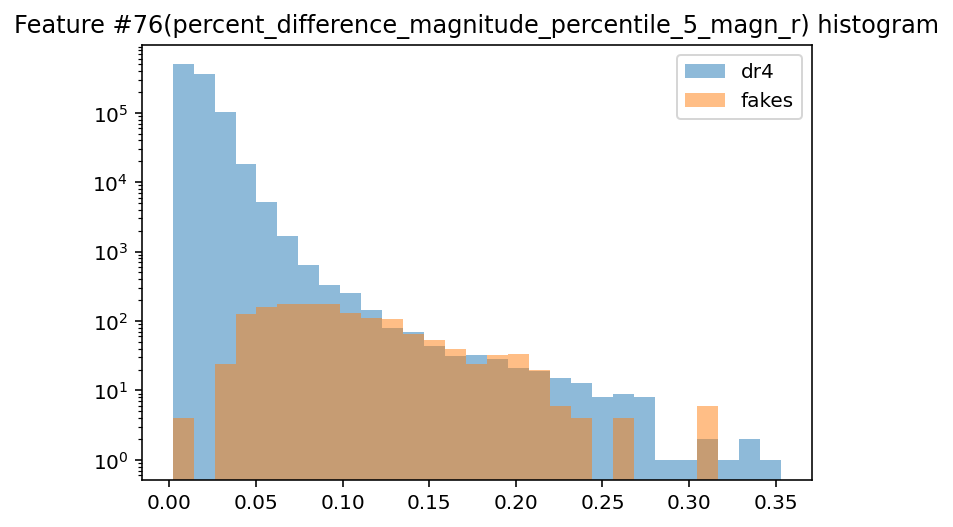

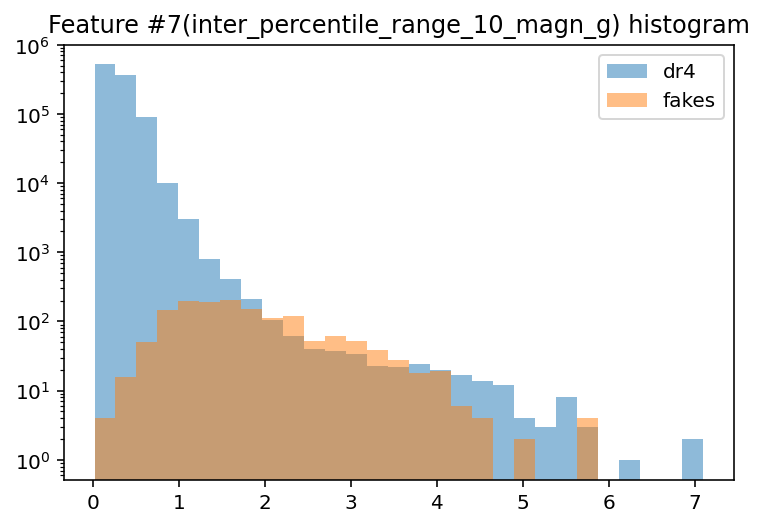

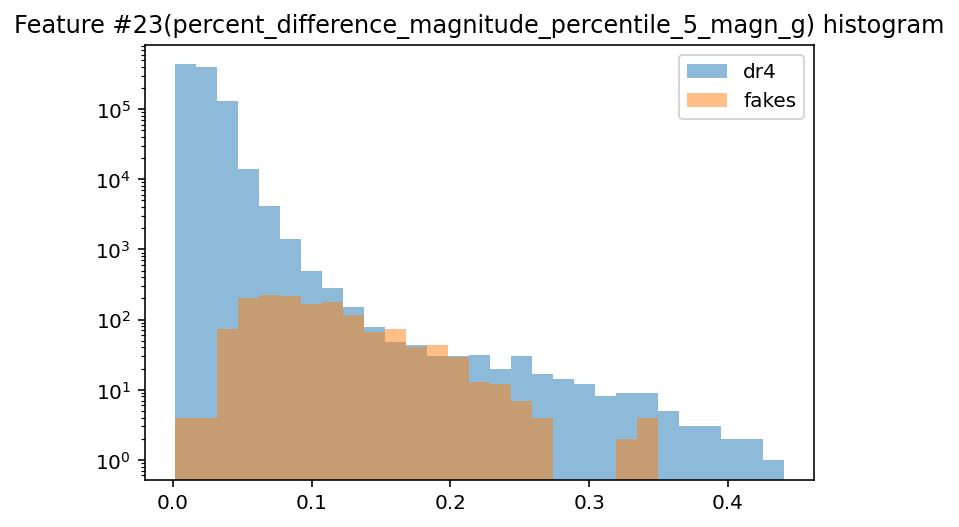

In [21]:
dr4_values_list, fakes_values_list, feature_list = [],[],[]

for root in roots:
    dr4_value, fakes_value, feature = plot_feature_histogram(root)
    plt.show()
    
    dr4_values_list.append(dr4_value)
    fakes_values_list.append(fakes_value)
    feature_list.append(feature)

In [22]:
dr4_values_list

[array([0.0170782 , 0.02028316, 0.0085202 , ..., 0.00555182, 0.01238895,
        0.01474143], dtype=float32),
 array([4.9396913e-05, 4.7306356e-05, 5.8669728e-05, ..., 2.0057376e-05,
        1.2599953e-05, 7.8671810e-06], dtype=float32),
 array([0.06700039, 0.0710001 , 0.03000069, ..., 0.01900005, 0.04599953,
        0.05000019], dtype=float32),
 array([0.2703991 , 0.31659985, 0.14100075, ..., 0.07439995, 0.21040154,
        0.21720028], dtype=float32),
 array([0.15850067, 0.10400009, 0.09499931, ..., 0.03249931, 0.07850075,
        0.10299969], dtype=float32),
 array([0.06850052, 0.05049896, 0.04799843, ..., 0.01699924, 0.03800201,
        0.04949999], dtype=float32),
 array([3.2716262e-04, 4.2506916e-04, 2.1503892e-04, ..., 6.2763917e-05,
        6.4838227e-05, 6.5799410e-05], dtype=float32),
 array([0.13700008, 0.25750065, 0.06575012, ..., 0.03625011, 0.09850121,
        0.0965004 ], dtype=float32),
 array([0.32127953, 0.42856026, 0.35136032, ..., 0.14972019, 0.3278389 ,
        0.3

In [23]:
fakes_values_list

[array([0.04225906, 0.10723786, 0.05416991, ..., 0.11891169, 0.1424722 ,
        0.09091491], dtype=float32),
 array([1.7757212e-04, 9.4749026e-05, 1.1712709e-04, ..., 7.5308526e-05,
        1.1425159e-04, 6.8853711e-05], dtype=float32),
 array([0.22814941, 0.5371628 , 0.27945614, ..., 0.4517765 , 0.7753315 ,
        0.44857407], dtype=float32),
 array([0.8787689, 2.1075287, 1.1087259, ..., 2.481077 , 2.7340603,
        1.9000587], dtype=float32),
 array([0.44583797, 1.2884293 , 0.45597267, ..., 0.59996796, 1.7457428 ,
        1.1622224 ], dtype=float32),
 array([0.20212936, 0.60020256, 0.20118237, ..., 0.30194283, 0.76626587,
        0.56897736], dtype=float32),
 array([0.00037344, 0.00037506, 0.00029515, ..., 0.00042744, 0.00065797,
        0.00027204], dtype=float32),
 array([0.45667934, 1.6119351 , 0.5946169 , ..., 1.171608  , 1.565155  ,
        1.1591072 ], dtype=float32),
 array([1.1579133, 2.4951248, 1.5246873, ..., 3.3386524, 3.652361 ,
        2.1634762], dtype=float32),
 arr

In [24]:
feature_list

['percent_difference_magnitude_percentile_10_magn_r',
 'linear_fit_slope_sigma_magn_r',
 'median_absolute_deviation_magn_r',
 'inter_percentile_range_10_magn_r',
 'inter_percentile_range_25_magn_g',
 'median_absolute_deviation_magn_g',
 'linear_trend_sigma_magn_r',
 'inter_percentile_range_25_magn_r',
 'inter_percentile_range_2_magn_r',
 'standard_deviation_magn_r',
 'percent_difference_magnitude_percentile_5_magn_r',
 'inter_percentile_range_10_magn_g',
 'percent_difference_magnitude_percentile_5_magn_g']

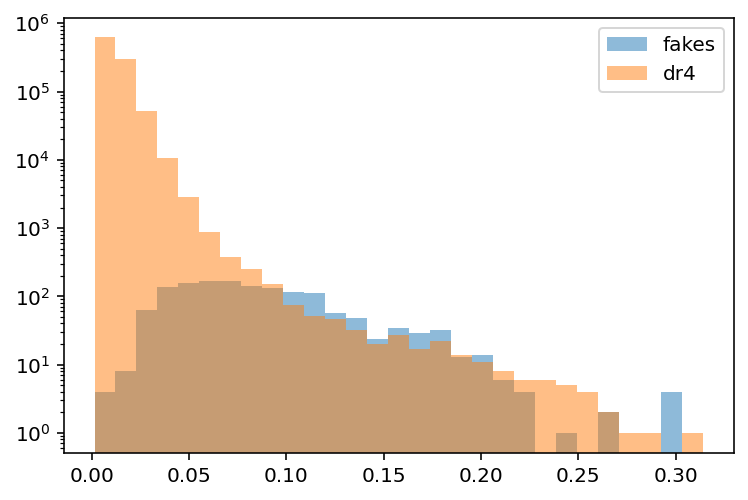

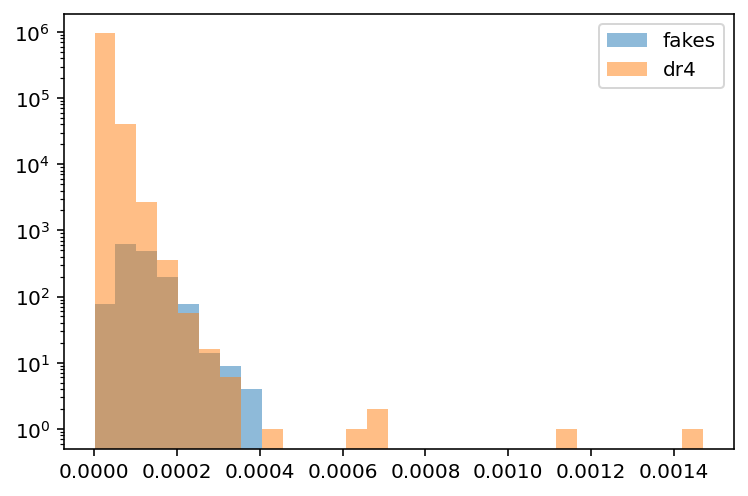

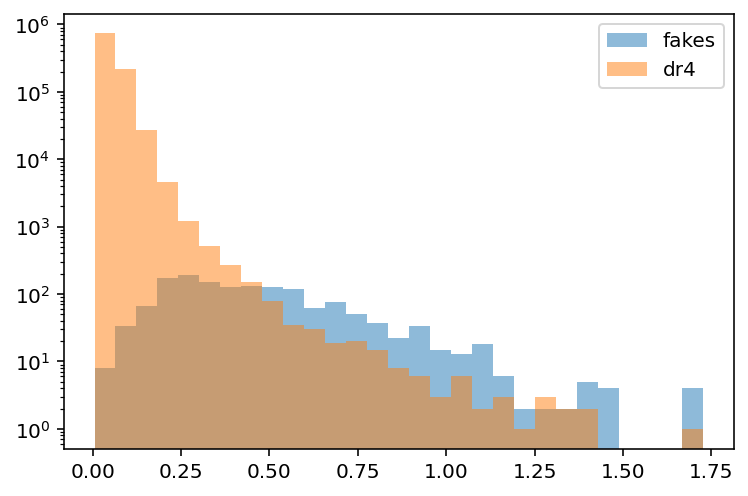

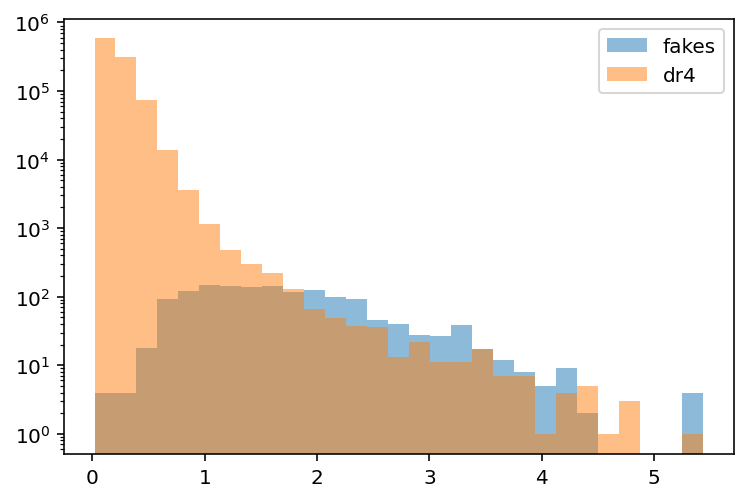

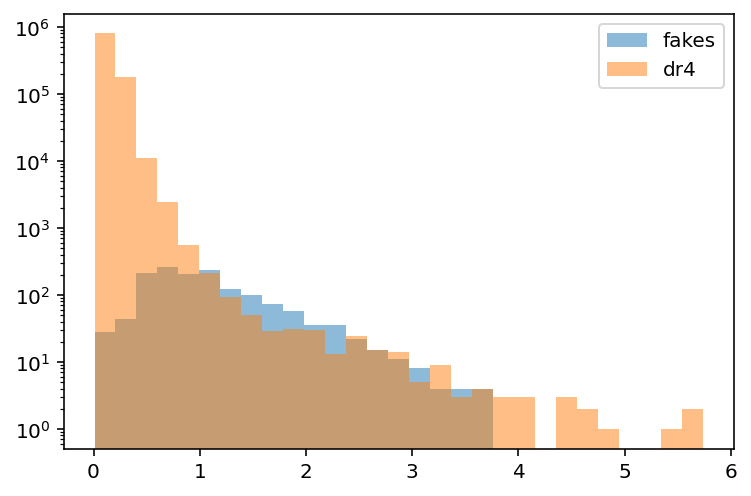

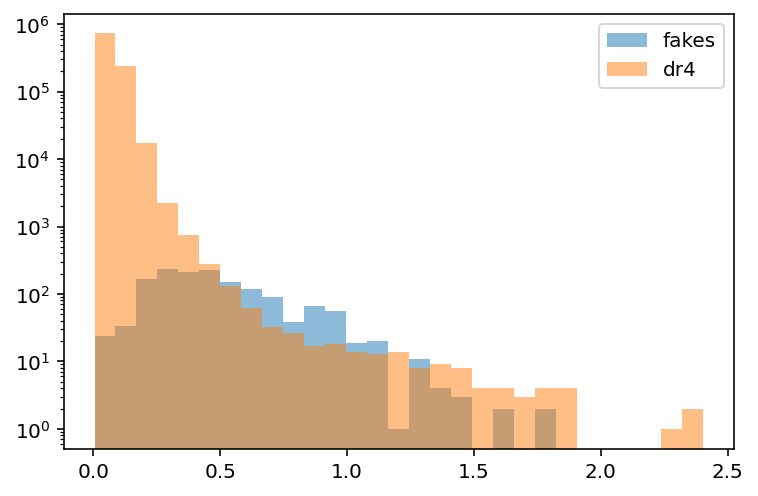

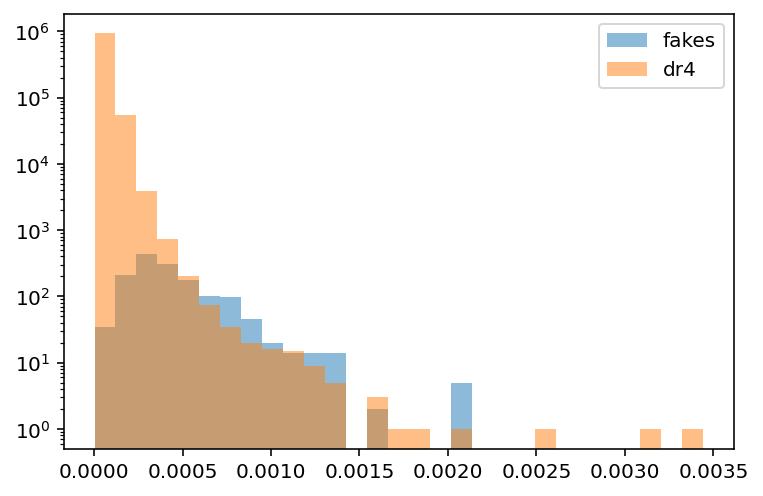

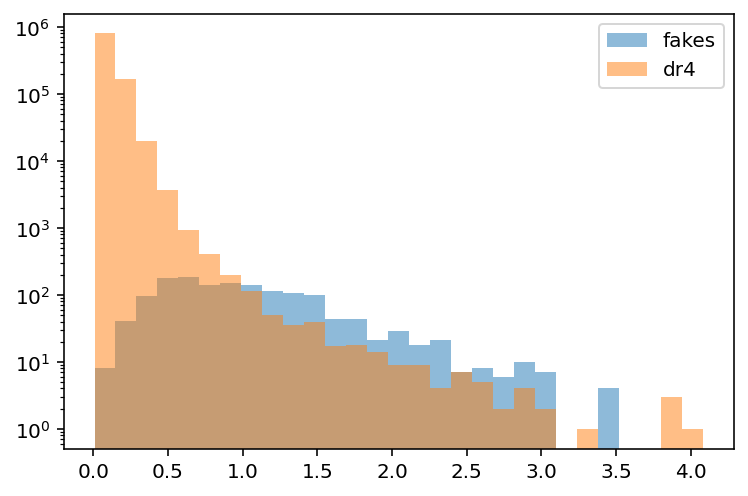

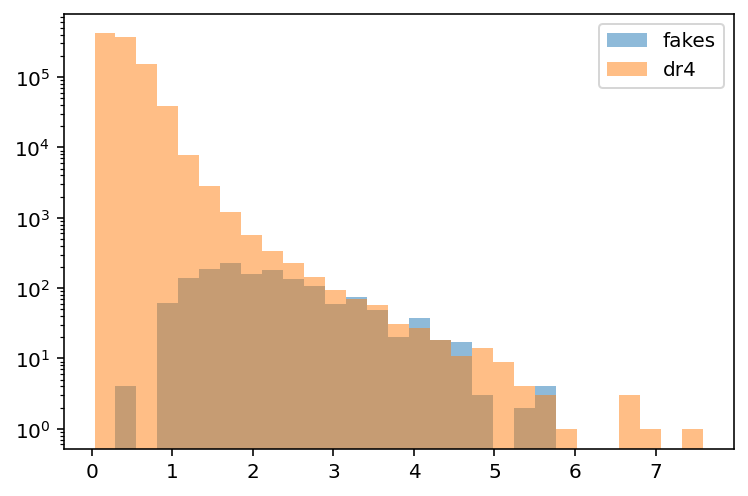

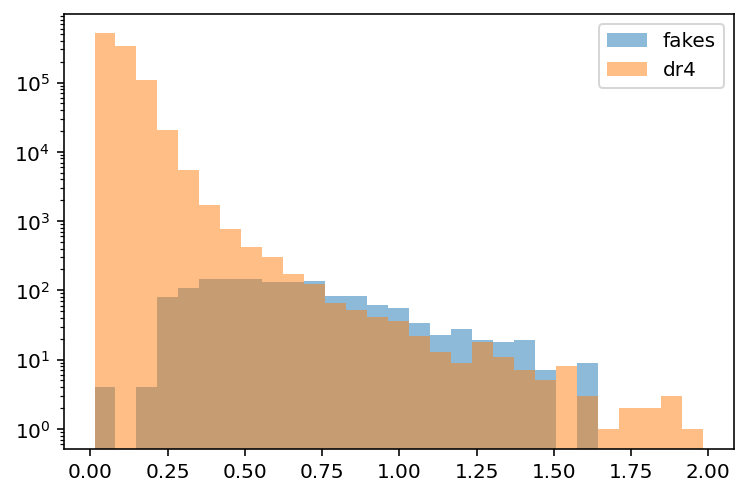

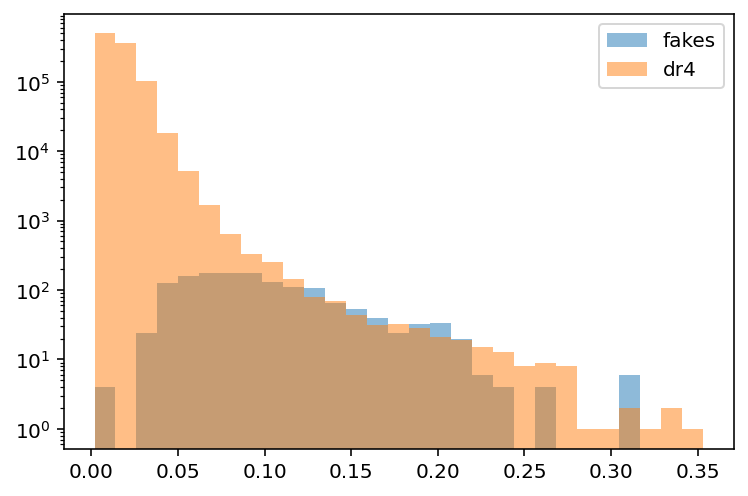

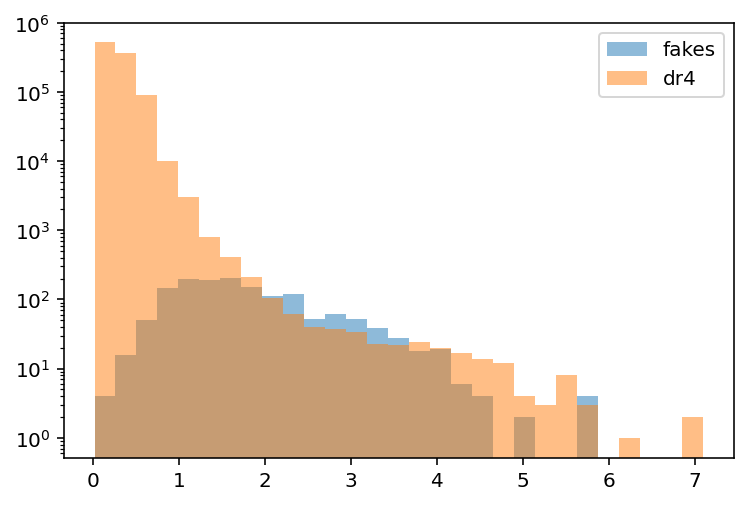

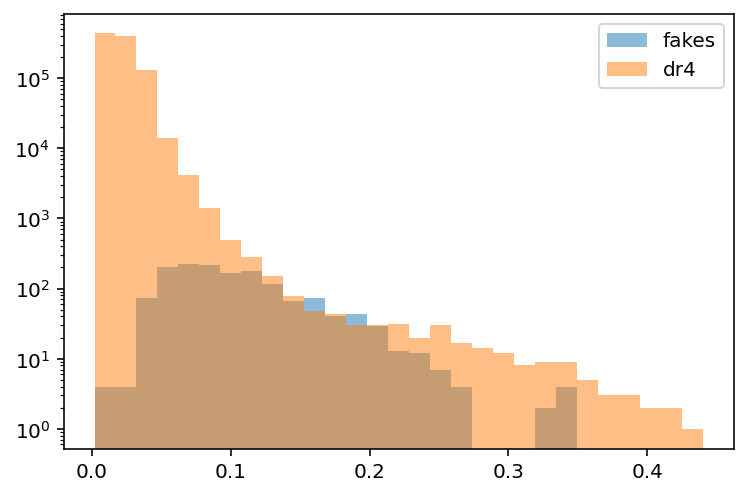

In [25]:
# Find and return only objects where dr4 and fakes overlap for features (so sims reflect reality)

for dr4_vs, fakes_vs, feat in zip(dr4_values_list, fakes_values_list, feature_list):
    
    min_dr4, max_dr4 = min(dr4_vs), max(dr4_vs) 
    fakes_vs = fakes_vs[(fakes_vs > min_dr4) & (fakes_vs < max_dr4)]
    
    bins = np.linspace(min_dr4, max_dr4, 30)
    plt.hist(fakes_vs, bins=bins, alpha=0.5, label='fakes')
    plt.hist(dr4_vs, bins=bins, alpha=0.5, label='dr4')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [26]:
dr4_index = [sids > 1e10]
dr4_sids = sids[dr4_index]
dr4_features = features[dr4_index]

fakes_index = [sids < 1e10]
fakes_sids = sids[fakes_index]
fakes_features = features[fakes_index]

<ipython-input-26-1290c42e22d8>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_sids = sids[dr4_index]
<ipython-input-26-1290c42e22d8>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_features = features[dr4_index]
<ipython-input-26-1290c42e22d8>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  fakes_sids 

In [27]:
for fid, feat in enumerate(feature_names):
    print(fid, feat)

0 amplitude_magn_g
1 anderson_darling_normal_magn_g
2 beyond_1_std_magn_g
3 beyond_2_std_magn_g
4 cusum_magn_g
5 eta_e_magn_g
6 inter_percentile_range_2_magn_g
7 inter_percentile_range_10_magn_g
8 inter_percentile_range_25_magn_g
9 kurtosis_magn_g
10 linear_fit_slope_magn_g
11 linear_fit_slope_sigma_magn_g
12 linear_fit_reduced_chi2_magn_g
13 linear_trend_magn_g
14 linear_trend_sigma_magn_g
15 magnitude_percentage_ratio_40_5_magn_g
16 magnitude_percentage_ratio_20_5_magn_g
17 maximum_slope_magn_g
18 mean_magn_g
19 median_absolute_deviation_magn_g
20 median_buffer_range_percentage_10_magn_g
21 median_buffer_range_percentage_20_magn_g
22 percent_amplitude_magn_g
23 percent_difference_magnitude_percentile_5_magn_g
24 percent_difference_magnitude_percentile_10_magn_g
25 period_0_magn_g
26 period_s_to_n_0_magn_g
27 period_1_magn_g
28 period_s_to_n_1_magn_g
29 period_2_magn_g
30 period_s_to_n_2_magn_g
31 period_3_magn_g
32 period_s_to_n_3_magn_g
33 period_4_magn_g
34 period_s_to_n_4_magn_g
3

In [28]:
feat_nums = list(np.linspace(0,105, 106, dtype=int)) 
eta_feats = list([5, 17, 25, 27, 29, 31, 33, 46, 58, 70, 78, 80, 82, 84, 86, 99])
dropeta_nums = np.array([x for x in feat_nums if x not in eta_feats])
drop_features_list = ['eta_e_magn_g', 
                      'maximum_slope_magn_g', 
                      'period_0_magn_g', 
                      'period_1_magn_g',
                      'period_2_magn_g',
                      'period_3_magn_g',
                      'period_4_magn_g',
                      'eta_e_flux_g',
                      'eta_e_magn_r',
                      'maximum_slope_magn_r',
                      'period_0_magn_r',
                      'maximum_slope_magn_r',
                      'period_0_magn_r',
                      'period_1_magn_r',
                      'period_2_magn_r',
                      'period_3_magn_r',
                      'period_4_magn_r',
                      'eta_e_flux_r']
dropeta_feature_names = [h for h in feature_names if h not in drop_features_list]

In [29]:
roots

array([77, 64, 72, 60,  8, 19, 67, 61, 59, 94, 76,  7, 23])

In [30]:
dropeta_nums

array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  26,  28,  30,
        32,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,  73,  74,
        75,  76,  77,  79,  81,  83,  85,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98, 100, 101, 102, 103, 104, 105])

In [31]:
roots_dr4_features = dr4_features[:, roots]
roots_fakes_features = fakes_features[:, roots]

dropeta_dr4_features = dr4_features[:, dropeta_nums]
dropeta_fakes_features = fakes_features[:, dropeta_nums]

In [32]:
dropeta_dr4_features[0]

array([ 1.77000046e-01,  3.69659615e+00,  3.70000005e-01,  2.99999993e-02,
        1.58870399e-01,  3.41499329e-01,  2.86500931e-01,  1.58500671e-01,
       -7.87381172e-01, -2.11601975e-04,  5.53548925e-05,  2.63070774e+01,
       -2.17129375e-04,  2.90960539e-04,  2.07376242e-01,  6.26722753e-01,
        1.64473038e+01,  6.85005188e-02,  1.09999999e-01,  2.09999993e-01,
        2.50499725e-01,  1.98312663e-02,  1.74551997e-02,  4.85962105e+00,
        2.74704218e+00,  2.65994835e+00,  2.61648917e+00,  2.39863539e+00,
        3.50511003e+00,  5.85937500e-02,  1.07421875e-02,  1.19613957e+00,
        2.61876163e+01,  7.01312542e-01,  1.05069116e-01,  8.43038440e-01,
        1.64416523e+01,  3.13831210e+00,  1.58622161e-01,  8.39881785e-03,
       -9.23616409e-01,  9.35243219e-02,  2.78804207e+01, -5.96580803e-01,
        8.53262544e-01,  1.80000305e-01,  3.13640451e+00,  3.39805812e-01,
        1.94174759e-02,  1.01484224e-01,  3.21279526e-01,  2.70399094e-01,
        1.37000084e-01, -

In [33]:
dropeta_fakes_features[0]

array([ 1.2342625e+00,  3.1930754e+00,  2.4218750e-01,  6.2500000e-02,
        2.6230100e-01,  1.5118084e+00,  9.6537644e-01,  4.4583797e-01,
        1.6474078e+00, -7.1752549e-04,  1.2483606e-04,  7.2344847e+00,
       -1.1002456e-03,  3.0588996e-04,  1.2562628e-01,  4.3264356e-01,
        2.0559959e+01,  2.0212936e-01,  3.6718750e-01,  5.7031250e-01,
        1.4955063e+00,  6.1463047e-02,  4.7168877e-02,  1.0371223e+01,
        9.9671297e+00,  6.5325251e+00,  3.7862439e+00,  2.8800311e+00,
        8.9260569e+00,  2.5390625e-02,  1.7578125e-02,  1.6400348e+00,
        7.4376502e+00,  1.8879598e-01,  3.8923508e-01,  7.9585379e-01,
        2.0514540e+01,  3.5382116e+00,  2.0159966e-01,  1.3999665e-01,
        2.6552483e+01,  3.9761505e-01,  8.8139791e+00,  3.5098305e+00,
        8.5319924e-01,  6.6409779e-01,  1.0396281e+00,  3.4782609e-01,
        2.6086956e-02,  2.7883193e-01,  1.1579133e+00,  8.7876892e-01,
        4.5667934e-01, -7.1139789e-01,  7.3970284e-04,  1.7757212e-04,
      

In [34]:
features

array([[ 1.7700005e-01,  3.6965961e+00,  3.7000000e-01, ...,
         4.3813328e+01, -5.0774747e-01,  8.4453022e-01],
       [ 2.9349995e-01,  2.7240112e+00,  2.8999999e-01, ...,
         8.2861153e+01, -5.9173141e-02,  9.0985739e-01],
       [ 3.2849979e-01,  5.4933901e+00,  1.9000000e-01, ...,
         1.3836402e+01,  2.4652200e+00,  6.8346423e-01],
       ...,
       [ 1.5952921e+00,  5.6317205e+00,  1.4545454e-01, ...,
         3.1220076e+01,  2.6328766e+00,  7.1172762e-01],
       [ 1.7225895e+00,  2.3856027e+00,  3.9622641e-01, ...,
         1.2833322e+02,  8.7820745e-01,  8.3187044e-01],
       [ 1.0965834e+00,  3.8629587e+00,  4.4094488e-01, ...,
         2.0336094e+01,  1.2858214e+00,  7.9160404e-01]], dtype=float32)

In [35]:
dropeta_all_features = features[:, dropeta_nums]
dropeta_all_features = dropeta_all_features.copy(order='C')

In [38]:
%%time

# Perform calculations of outliers

dropeta_isoforest = IsolationForest(n_subsamples=1024, n_trees=1000) # n_subsamples=1024, n_trees=1000
dropeta_isoforest.fit(dropeta_all_features)
dropeta_scores = dropeta_isoforest.score_samples(dropeta_all_features)
dropeta_ordered_sids = sids[np.argsort(dropeta_scores)]
dropeta_detection_curve = np.cumsum(dropeta_ordered_sids < 1e10)

CPU times: user 1min 36s, sys: 194 ms, total: 1min 36s
Wall time: 1min 36s


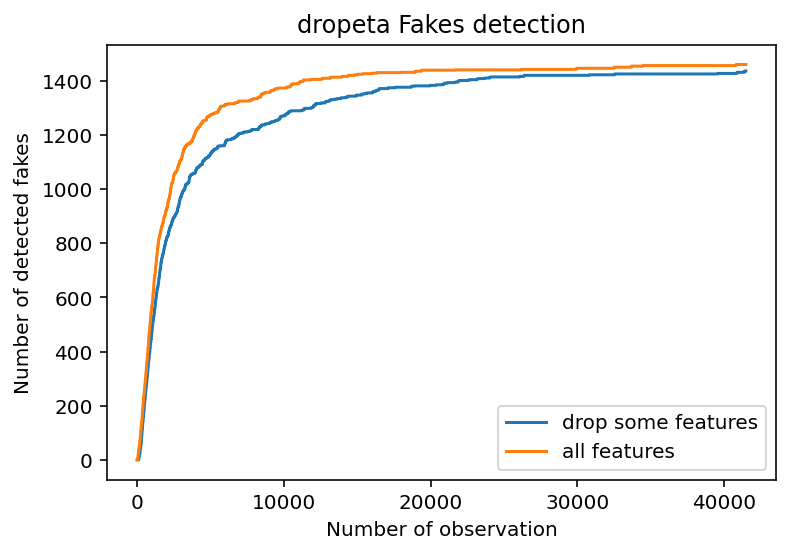

In [40]:
# Plot the detection curve

dropeta_n_fakes = dropeta_detection_curve[-1]

plt.plot(dropeta_detection_curve[:dropeta_n_fakes+40000], label='drop some features') # 10000 is for extragal_short_gr_100.tar
plt.plot(detection_curve[:n_fakes+40000], label='all features') # 10000 is for extragal_short_gr_100.tar

plt.xlabel('Number of observation')
plt.ylabel('Number of detected fakes')
plt.title('dropeta Fakes detection')
plt.legend();
pass

In [ ]:
%%time

#from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree

# With roots
#X = roots_fakes_features
#kdtree = KDTree(roots_dr4_features)              
#dist, ind = kdtree.query(X, k=2)

# all features
#X = fakes_features
#kdtree = cKDTree(dr4_features)              
#dist, ind = kdtree.query(X, k=2)

# all features EXCEPT ETA + OTHERS
X = dropeta_fakes_features
kdtree = cKDTree(dropeta_dr4_features)              
dist, ind = kdtree.query(X, k=2)

print(dist[:, 1])    # drop id; assumes sorted -> see args!
print(ind[:, 1])     # drop id

In [ ]:
plt.hist(dist[:, 1])

In [ ]:
plt.hist(ind[:, 1])

In [ ]:
# Number closest objects within distance (set threshold)
# Of fakes, what are fakes index w/ closest distance to real data?
threshold = 7
closest_dist_index = np.argwhere(dist[:, 1] <= threshold).ravel()
print('Total # of convincing fakes (no duplicate):', len(closest_dist_index))
print(closest_dist_index)

In [ ]:
fakes_sids_of_closest_dist = fakes_sids[closest_dist_index]
#fakes_features_of_closest_dist = fakes_features[closest_dist_index]
fakes_features_of_closest_dist = dropeta_fakes_features[closest_dist_index]
print('Real # of convincing fakes (no duplicates):', len(set(fakes_sids_of_closest_dist)))
set(fakes_sids_of_closest_dist)

In [ ]:
dr4_sids_of_closest_dist = dr4_sids[closest_dist_index]
#dr4_features_of_closest_dist = dr4_features[closest_dist_index]
dr4_features_of_closest_dist = dropeta_dr4_features[closest_dist_index]

dr4_sids_of_closest_dist

In [ ]:
closest_match_df = pd.DataFrame(zip(fakes_sids_of_closest_dist, dr4_sids_of_closest_dist), columns=[f'fakes_sids_of_dist<{threshold}', 'dr4_sids_of_match'])
closest_match_df

In [ ]:
np.unique(closest_match_df[f'fakes_sids_of_dist<{threshold}'])

In [ ]:
for simid in np.unique(closest_match_df[f'fakes_sids_of_dist<{threshold}']):
    simid = str(simid) 
    
    # first two digits are class, not actual ID from simulation
    if simid.startswith('42'):  # SN II
        plot_lightcurves_id(int(simid[2:]), X42, 'gr', None) 
        
    elif simid.startswith('60'):  # SLSN-I
        plot_lightcurves_id(int(simid[2:]), X60, 'gr', None) 
        
    elif simid.startswith('62'):  # SLSN-I
        plot_lightcurves_id(int(simid[2:]), X62, 'gr', None)
        
    elif simid.startswith('64'):  # TDE
        plot_lightcurves_id(int(simid[2:]), X64, 'gr', None) 
        
    elif simid.startswith('90'):  # SN Ia
        plot_lightcurves_id(int(simid[2:]), X90, 'gr', None)

In [ ]:
np.unique(closest_match_df['dr4_sids_of_match'])

In [ ]:
len(fakes_features_of_closest_dist[0])

In [ ]:
plt.hist(dr4_features_of_closest_dist[0]-fakes_features_of_closest_dist[0], bins=np.linspace(-10,10, 30));
plt.xlabel('DR4-Fakes feature Difference');

In [ ]:
plt.hist(fakes_features_of_closest_dist[0], alpha=0.5, bins=100);

In [ ]:
plt.hist(dr4_features_of_closest_dist[0], alpha=0.5, bins=100);

In [ ]:

#for featid, feat in enumerate(feature_names):
for featid, feat in enumerate(dropeta_feature_names):
    print(f'{featid} {feat} DR4:', dr4_features_of_closest_dist[0][featid], 'FAKE:',  fakes_features_of_closest_dist[0][featid], 
         '\n DIFFERENCE:', dr4_features_of_closest_dist[0][featid]- fakes_features_of_closest_dist[0][featid], '\n')

# TODO: recalculate FAKES DETECTIONS CURVES AFTER DROPPED FEATURES!

In [ ]:
len(dropeta_feature_names)

In [ ]:
closest_match_df[f'fakes_sids_of_dist<{threshold}'][0]

In [ ]:
import light_curve as lc
feature = lc.InterPercentileRange(0.02)
data = X64.loc[8956459]
feature(data['mjd_r'], data['mag_r'].astype(float), data['magerr_r'].astype(float))

In [ ]:
fakes_sids_of_closest_dist[0]

In [ ]:
fakes_features_of_closest_dist[0]